In [35]:
# this code block import necessary libraries for this project
! pip install -qU langchain langchain_openai langgraph arxiv duckduckgo-search pubmed wolframalpha duckduckgo_search==5.3.1b1
# !pip install -qU langchain langchain_openai langchain-community langchain_core qdrant_client langgraph arxiv duckduckgo_search==5.3.1b1

To effectively present the purpose of my mental health bot on Demo Day, consider focusing on the following key aspects:

1. **User Needs**: Highlight the specific mental health challenges your app addresses, such as anxiety, depression, or stress management.
2. **Features**: Showcase the unique features of your app, like mood tracking, meditation exercises, or therapist connections.
3. **Scientific Basis**: Emphasize any scientific research or evidence that supports the effectiveness of your app.
4. **User Experience**: Discuss how your app provides a user-friendly and engaging experience.
5. **Impact**: Share any success stories or data that demonstrate the positive impact your app has had on users' mental health.

By covering these points, you can clearly convey the value and purpose of your mental health app to your audience.

In [11]:
! pip install -qU faiss-cpu pymupdf

In [12]:
#
from langchain.document_loaders import ArxivLoader

# Load papers on mental health and solutions
docs = ArxivLoader(
    query="mental health AND (treatment OR therapy OR intervention)",
    load_max_docs=10,
    sort_by="submittedDate",
    sort_order="descending"
).load()

In [30]:
list(doc.metadata.keys())

['Published', 'Title', 'Authors', 'Summary']

In [32]:
for doc in docs[:2]:
    print(f"Title: {doc.metadata['Title']}")
    print(f"Abstract: {doc.page_content[:300]}...")  # Print first 300 characters of abstract
    print("=================================================================================")

Title: Supporting Therapeutic Relationships and Communication about Mental Health
Abstract:  
Supporting Therapeutic Relationships and 
Communication about Mental Health
 
Introduction and background 
Effective communication and strong therapeutic 
relationships are critical to successful mental health 
interventions. For example, in 1957 Carl Rogers, a 
pioneer of person-centred therapy, ...
Title: The Role of Mandated Mental Health Treatment in the Criminal Justice System
Abstract: The Role of Mandated Mental Health Treatment in the
Criminal Justice System
Rachel Nesbit*
November 14, 2023
Abstract
Mental health disorders are particularly prevalent among those in the criminal justice system
and may be a contributing factor in recidivism. Using North Carolina court cases from 19...


In [3]:
# This code block imports the necessary modules: os for interacting with the operating system and getpass for securely prompting the user for input without echoing the input to the console.
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [52]:
# Similar to the previous code block, this one prompts the user to enter their Wolfram Alpha App ID using getpass.getpass().
import os

os.environ["WOLFRAM_ALPHA_APPID"] = getpass.getpass ("WOLFRAM_ALPHA_APPID")

In [33]:
# from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE3 - LangGraphDemo -{'5a4498e2'}"#{uuid4().hex[0:8]}"# {'9dc7f3da'}
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

In [34]:
{uuid4().hex[0:8]}

{'5a4498e2'}

In [40]:
# This code block imports necessary classes from langchain and langchain_community libraries.
# It uses the ArxivLoader to load a maximum of 5 documents from arXiv related to the query "Mental Health".
# The loaded documents are then split into chunks using the RecursiveCharacterTextSplitter with a chunk size of 500 characters and an overlap of 50 characters between chunks.
# The chunked documents are then used to create a vector store using the FAISS class from langchain_community.
# The OpenAIEmbeddings class is used to generate embeddings for the documents using the "text-embedding-3-small" model.
# Finally, a retriever object is created from the faiss_vectorstore to enable retrieval of relevant documents based on queries.
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import ArxivLoader
from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings


docs = ArxivLoader(
    query="\"mental health counseling\" AND (data OR analytics OR \"machine learning\")",
    load_max_docs=10,
    sort_by="submittedDate",
    sort_order="descending"
).load()

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=50
)

chunked_documents = text_splitter.split_documents(docs)

faiss_vectorstore = FAISS.from_documents(
    documents=chunked_documents,
    embedding=OpenAIEmbeddings(model="text-embedding-3-small"),
)

retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 5})

In [526]:
# This code block imports the ChatPromptTemplate class from langchain_core.prompts.
# It defines a prompt template named RAG_PROMPT using a multi-line string. The prompt template includes placeholders for the user's question ({question}) and the relevant context ({context}).
# The ChatPromptTemplate.from_template() method is used to create a prompt object named rag_prompt from the RAG_PROMPT template.
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Your are a professional mental helth advisor. Use the following context to answer the user's query. If you cannot answer the question, please respond with 'I don't know'.

Question:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [6]:
# This code block imports the ChatOpenAI class from langchain_openai.
# It creates an instance of the ChatOpenAI class named openai_chat_model with the model set to "gpt-3.5-turbo".
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-3.5-turbo")

### Using Parent Document retriever

In [41]:
from langchain.retrievers import ParentDocumentRetriever
from langchain_qdrant import Qdrant
from langchain.storage import InMemoryStore
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

client = QdrantClient(":memory:")
client.create_collection(
    collection_name="split_parents",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vectorstore = Qdrant(client, collection_name="split_parents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"))

store = InMemoryStore()

In [42]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

parent_document_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=RecursiveCharacterTextSplitter(chunk_size=400),
    parent_splitter=RecursiveCharacterTextSplitter(chunk_size=2000),
)
parent_document_retriever.add_documents(docs)

In [38]:
# This code block imports necessary classes and functions from langchain.
# It creates a retrieval-augmented generation chain named retrieval_augmented_generation_chain.
# The chain is defined using the LCEL (LangChain Expression Language) syntax.
# It starts by retrieving the context based on the user's question using the retriever object and the itemgetter function.
# The retrieved context is then assigned to the context variable using the RunnablePassthrough.assign() method.
# The rag_prompt is then used to generate a response using the openai_chat_model based on the user's question and the retrieved context.

from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough

def create_qa_chain(retriever):

  mentahealth_qa_llm =openai_chat_model

  created_qa_chain = (
    {"context": itemgetter("question") | retriever,
     "question": itemgetter("question")
    }
    | RunnablePassthrough.assign(
        context=itemgetter("context")
      )
    | {
         "response": rag_prompt | mentahealth_qa_llm | StrOutputParser(),
         "context": itemgetter("context"),
      }

  )
  return created_qa_chain

In [21]:
# ! pip install datasets

In [23]:
from datasets import load_dataset

ds = load_dataset("Amod/mental_health_counseling_conversations")

In [24]:
from datasets import DatasetDict

ds_train_test=ds['train'].train_test_split(train_size=0.8)
ds_test_valid=ds_train_test['test'].train_test_split(test_size=.5)
mental_health_counseling_data= DatasetDict({

    'train': ds_train_test['train'],
    'validation': ds_test_valid['train'],
    'test': ds_test_valid['test']

})

mental_health_counseling_data

DatasetDict({
    train: Dataset({
        features: ['Context', 'Response'],
        num_rows: 2809
    })
    validation: Dataset({
        features: ['Context', 'Response'],
        num_rows: 351
    })
    test: Dataset({
        features: ['Context', 'Response'],
        num_rows: 352
    })
})

In [43]:
parent_document_retriever_qa_chain = create_qa_chain(parent_document_retriever)
await parent_document_retriever_qa_chain.ainvoke({'question': mental_health_counseling_data["test"][2]['Context']})
# output['response']

{'response': "I don't know.",
 'context': [Document(metadata={'Published': '2024-06-13', 'Title': 'Enhancing Psychotherapy Counseling: A Data Augmentation Pipeline Leveraging Large Language Models for Counseling Conversations', 'Authors': 'Jun-Woo Kim, Ji-Eun Han, Jun-Seok Koh, Hyeon-Tae Seo, Du-Seong Chang', 'Summary': "We introduce a pipeline that leverages Large Language Models (LLMs) to\ntransform single-turn psychotherapy counseling sessions into multi-turn\ninteractions. While AI-supported online counseling services for individuals\nwith mental disorders exist, they are often constrained by the limited\navailability of multi-turn training datasets and frequently fail to fully\nutilize therapists' expertise. Our proposed pipeline effectively addresses\nthese limitations. The pipeline comprises two main steps: 1) Information\nExtraction and 2) Multi-turn Counseling Generation. Each step is meticulously\ndesigned to extract and generate comprehensive multi-turn counseling\nconversat

In [527]:
# change of behavior of system! <You are a professional Mental Health Advisor> added.
await create_qa_chain(retriever).ainvoke({"question" : mental_health_counseling_data["test"][2]['Context']})

2024-07-17 12:39:00 - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-07-17 12:39:02 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'response': "It's understandable to feel sad after losing people who made you happy. It's important to focus on self-care and activities that bring you joy and relaxation. Engage in hobbies, exercise, spend time in nature, or connect with supportive friends or family members. It may also be helpful to seek professional counseling or therapy to work through your emotions and develop coping strategies. Remember, it's okay to seek help and take time to heal.",
 'context': [Document(metadata={'Published': '2023-08-17', 'Title': 'Building Emotional Support Chatbots in the Era of LLMs', 'Authors': 'Zhonghua Zheng, Lizi Liao, Yang Deng, Liqiang Nie', 'Summary': 'The integration of emotional support into various conversational scenarios\npresents profound societal benefits, such as social interactions, mental health\ncounseling, and customer service. However, there are unsolved challenges that\nhinder real-world applications in this field, including limited data\navailability and the absence 

#### sounds like no solution using research papers!

In [64]:
# ! pip install wolframalpha

In [523]:
# This code block imports various tool classes from the langchain_community library.
# It creates a list named tool_belt that contains instances of the following tools:
# ArxivQueryRun(): A tool for running queries on the arXiv database.
# DuckDuckGoSearchRun(): A tool for performing searches using the DuckDuckGo search engine.
# The PubmedQueryRun() and WolframAlphaAPIWrapper() tools are commented out and not included in the tool_belt.

from langchain_community.tools.arxiv.tool import ArxivQueryRun 
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper
from langchain_community.tools.pubmed.tool import PubmedQueryRun
from langchain_core.tools import BaseTool


from langchain.tools import tool

@tool
def rag_tool(question: str) -> str:
    """Use this tool to retrieve relevant information from the knowledge base."""
    # advanced_rag_prompt=ChatPromptTemplate.from_template(INSTRUCTION_PROMPT_TEMPLATE.format(user_query=question))
    parent_document_retriever_qa_chain = create_qa_chain(parent_document_retriever)
    response=parent_document_retriever_qa_chain.invoke({'question': question})['response']

    return response


tool_belt = [
    rag_tool,
    # PubmedQueryRun,
    ArxivQueryRun(),
    DuckDuckGoSearchRun(),
]

In [524]:
# This code block imports the ToolExecutor class from the langgraph.prebuilt module.
# It creates an instance of the ToolExecutor class named tool_executor and passes the tool_belt as an argument.
# The ToolExecutor is responsible for executing the tools in the tool_belt based on the provided input.
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tool_belt)

ValueError: Value not declarable with JSON Schema, field: name='callback_manager' type=Optional[BaseCallbackManager] required=False default=None

In [466]:
# This code block imports the ChatOpenAI class from the langchain_openai module.
# It creates an instance of the ChatOpenAI class named model with the temperature parameter set to 0.
# The temperature parameter controls the randomness of the generated responses. A value of 0 means the model will generate deterministic responses.
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)

In [467]:
# This code block imports the convert_to_openai_function function from the langchain_core.utils.function_calling module.
# It creates a list named functions by applying the convert_to_openai_function function to each tool in the tool_belt.
# The convert_to_openai_function function converts the tools into a format compatible with OpenAI's function calling API.
# It then binds the converted functions to the model using the bind_functions() method, allowing the model to utilize the tools during generation.
from langchain_core.utils.function_calling import convert_to_openai_function

functions = [convert_to_openai_function(t) for t in tool_belt]
model = model.bind_functions(functions)

In [468]:
#  This code block imports necessary types and classes from the typing module and the langchain_core.messages module.
# It defines a custom type named AgentState using the TypedDict class from the typing module.
# The AgentState type has a field named messages of type Annotated[Sequence[BaseMessage], operator.add].
# Sequence[BaseMessage] indicates that messages is a sequence of BaseMessage objects.
# Annotated is used to attach metadata to the type, in this case, specifying that the messages field should be treated as a concatenable sequence using the operator.add function.
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], operator.add]

In [469]:
# This code block imports necessary classes and functions from the langgraph.prebuilt, json, and langchain_core.messages modules.
# It defines two functions: call_model and call_tool.
# The call_model function takes the state as input, extracts the messages from the state, invokes the model with the messages, and returns a dictionary containing the response message.
# The call_tool function takes the state as input, extracts the last message from the state, creates a ToolInvocation object using the tool name and arguments from the last message, invokes the tool_executor with the ToolInvocation, creates a FunctionMessage object with the tool response and name, and returns a dictionary containing the FunctionMessage.
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

def call_tool(state):
  last_message = state["messages"][-1]

  action = ToolInvocation(
      tool=last_message.additional_kwargs["function_call"]["name"],
      tool_input=json.loads(
          last_message.additional_kwargs["function_call"]["arguments"]
      )
  )

  response = tool_executor.invoke(action)

  function_message = FunctionMessage(content=str(response), name=action.tool)

  return {"messages" : [function_message]}

In [181]:
# This code block imports the StateGraph and END classes from the langgraph.graph module.
# It creates an instance of the StateGraph class named workflow with the AgentState type.
# It adds two nodes to the workflow using the add_node() method:
# The "agent" node is associated with the call_model function.
# The "action" node is associated with the call_tool function.
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)
workflow.set_entry_point('agent')

#-------------------------------
# This code block defines a function named should_continue that takes the state as input.
# The should_continue function checks the last message in the state to determine whether to continue or end the workflow.
# If the last message does not have a "function_call" in its additional_kwargs, it returns "end".
# Otherwise, it returns "continue".
# It adds conditional edges to the workflow using the add_conditional_edges() method.
# The conditional edges originate from the "agent" node and are based on the should_continue function.
# If the should_continue function returns "continue", the workflow transitions to the "action" node.
# If the should_continue function returns "end", the workflow transitions to the END node, indicating the end of the workflow.
def should_continue(state):
  last_message = state["messages"][-1]

  if "function_call" not in last_message.additional_kwargs:
    return "end"

  return "continue"

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue" : "action",
        "end" : END
    }
)
# --------------------------------------------

workflow.add_edge("action", "agent")
workflow.compile()

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden'], 'metadata': {}}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<messages>(recurse=True, writes=[ChannelWriteEntry(channel='messages', value=<object object at 0x7efba009c3a0>, skip_none=False, mapper=_get_state_key(recurse=False))], require_at_least_one_of=['messages']), ChannelWrite<start:agent>(recurse=True, writes=[ChannelWriteEntry(channel='start:agent', value='__start__', skip_none=False, mapper=None)], require_at_least_one_of=None)]), 'agent': PregelNode(config={'tags': [], 'metadata': {}}, channels={'messages': 'messages'}, triggers=['action', 'start:agent'], mapper=functools.partial(<function _coerce_state at 0x7efba0132950>, <class '__main__.AgentState'>), writers=[ChannelWrite<agent,messages>(recurse=True, writes=[ChannelWriteEntry(channel='agent', value='agent', skip_none=False, mapper=None), ChannelWriteEntry(channel='messages', value=<object object at 0x7efba009c3a

In [470]:

#-------------------------------
# This code block defines a function named should_continue that takes the state as input.
# The should_continue function checks the last message in the state to determine whether to continue or end the workflow.
# If the last message does not have a "function_call" in its additional_kwargs, it returns "end".
# Otherwise, it returns "continue".
# It adds conditional edges to the workflow using the add_conditional_edges() method.
# The conditional edges originate from the "agent" node and are based on the should_continue function.
# If the should_continue function returns "continue", the workflow transitions to the "action" node.
# If the should_continue function returns "end", the workflow transitions to the END node, indicating the end of the workflow.
def get_state_update_bot():

  workflow = StateGraph(AgentState)

  workflow.add_node("agent", call_model)# agent node has access to llm
  workflow.add_node("action", call_tool)# action node has access to tools
  workflow.set_entry_point('agent')
  workflow.add_conditional_edges(
      "agent",
      should_continue,
      {
          "continue" : "action",#tools
          "end" : END
      }
  )
  workflow.add_edge("action", "agent")#tools
  state_update_bot=workflow.compile()

  return state_update_bot

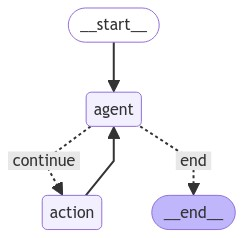

In [471]:
from IPython.display import Image, display

try:
    display(Image(get_state_update_bot().get_graph().draw_mermaid_png()))#state_update_bot
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [100]:
app=workflow.compile()

In [472]:
# This code block imports the HumanMessage class from the langchain_core.messages module.
# It creates a dictionary named inputs containing a list of messages, which in this case consists of a single HumanMessage with the content "What is the fundamental mechanism behind CRISPR-Cas9 gene editing, and how does it differ from other gene editing techniques?".
# It invokes the compiled workflow app using the invoke() method, passing the inputs dictionary as an argument.
# The workflow processes the input message, executes the defined nodes and edges, and returns the generated response.
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content=mental_health_counseling_data['test'][2]["Context"])]}

print(app.invoke(inputs))

{'messages': [HumanMessage(content='How do I make myself happy without the people who made me happy? Now that they’re gone, I feel sad. It’s been two months now but I seem to be unable to stay okay and independent.'), AIMessage(content="I'm sorry to hear that you're going through a tough time. It's completely normal to feel sad and miss the people who made you happy. Here are some tips that might help you make yourself happy and feel more independent:\n\n1. **Practice Self-Care**: Take care of yourself by getting enough sleep, eating well, exercising, and practicing relaxation techniques like meditation or deep breathing.\n\n2. **Engage in Activities You Enjoy**: Focus on activities that bring you joy and fulfillment, whether it's a hobby, exercise, reading, or spending time in nature.\n\n3. **Connect with Supportive People**: Reach out to friends, family members, or a therapist who can provide emotional support and understanding during this time.\n\n4. **Set Goals and Prioritize Self-

In [473]:
output=app.invoke(inputs)

In [474]:
print(output['messages'][-1].content)

I'm sorry to hear that you're going through a tough time. It's completely normal to feel sad and miss the people who made you happy. Here are some tips that may help you make yourself happy and feel more independent:

1. **Practice Self-Care**: Take care of yourself by getting enough sleep, eating well, exercising, and engaging in activities that bring you joy.

2. **Set Goals**: Setting small, achievable goals for yourself can give you a sense of purpose and accomplishment.

3. **Stay Connected**: While the people who made you happy may be gone, try to stay connected with friends and family who support you and make you feel good.

4. **Find New Hobbies**: Explore new hobbies or activities that interest you. This can help you discover new passions and meet new people.

5. **Practice Gratitude**: Take time each day to reflect on the things you are grateful for. This can help shift your focus to the positive aspects of your life.

6. **Seek Professional Help**: If you're struggling to co

In [475]:
mental_health_counseling_data['test'][2]['Response']

"It sounds like you have been feeling pretty down, since the loss of a relationship, and you're wondering how to be happy by yourself. Intimacy is a very natural human desire and at the same time learning to enjoy ourselves, even when we are alone, can strengthen our ability to lead a satisfying life in and out of relationship. Working with a therapist, you may be able to gain insight into how you show up in your relationships with yourself and others and discover more fulfilling ways to do so."

In [192]:
inputs

{'messages': [HumanMessage(content='How do I make myself happy without the people who made me happy? Now that they’re gone, I feel sad. It’s been two months now but I seem to be unable to stay okay and independent.')]}

In [216]:
# # Define the function to convert inputs
# def convert_inputs(input_object):
#     system_prompt = f"""You are a qualified psychologist providing mental health advice. Your task is to:

#     1. Analyze the user's question to identify potential mental health issues.
#     2. Provide a brief, one-sentence response addressing the main concern.
#     3. Ask a follow-up question to gather more information about the user's specific situation.
#     4. Based on the identified issue, provide:
#        a) A tailored diet plan in structured format
#        b) A physical activity schedule in structured format
#        c) An action plan or resources for further support
#     5. If the situation requires more in-depth assistance, provide a link to schedule an in-person meeting.

#     Use the following tools in this order:
#     1. RAG (Retrieval-Augmented Generation) to access relevant mental health information.
#     2. InternetSearch to find up-to-date resources and recommendations.
#     3. Find a relevant spiritual music

#     You may make multiple calls to these tools as needed to provide comprehensive advice.

#     Present your final response in a clear, structured format, including a chart of recommended actions if appropriate.

#     User's question: {input_object['question']}

#     Response:
#     """
#     return {"messages": [HumanMessage(content=system_prompt)]}

# # Define the function to parse the output
# def parse_output(input_state):
#     return input_state["messages"][-1].content

# bot=get_state_update_bot()
# # Create the agent chain
# agent_chain = convert_inputs | bot | parse_output

# # Run the agent chain with the input
# await agent_chain.ainvoke({"question": mental_health_counseling_data['test'][2]['Context']})


"Based on the information gathered, here is a brief response to your question:\n\nResponse: To make yourself happy without relying on others, it is important to differentiate between emotional dependence and emotional support, take charge of your own life, embrace change, and cultivate supportive relationships.\n\nFollow-up question: Can you share more about the activities or hobbies that used to bring you joy when you were with the people who made you happy?\n\nNow, let's proceed with providing a tailored diet plan, physical activity schedule, and an action plan for further support based on the identified issue.\n### Tailored Diet Plan:\n- Focus on consuming a balanced diet rich in fruits, vegetables, whole grains, lean proteins, and healthy fats.\n- Incorporate mood-boosting foods such as fatty fish, nuts, seeds, and dark chocolate.\n- Stay hydrated by drinking plenty of water throughout the day.\n\n### Physical Activity Schedule:\n- Engage in regular physical exercise such as walkin

In [476]:
def convert_inputs(input_object):
    system_prompt = f"""You are a qualified psychologist providing mental health advice. Be empathetic in your responses. 


Use a compassionate yet direct tone, avoiding excessive reassurance or filler phrases.
Include relevant concepts or theories that might help explain the situation (e.g., codependency, time management, intimacy issues).
When applicable, mention potential external factors that could be influencing the situation (e.g., pregnancy affecting sex drive, seasonal changes affecting mood).
Encourage the user to seek additional support from trusted sources (e.g., family members, school counselors) if professional help is not immediately accessible.
Offer alternative perspectives to help reframe the issue.
Provide concise responses for simpler questions, but offer more detailed explanations for complex issues.
Use examples or analogies to illustrate points when helpful.
End with a brief statement of encouragement or invitation for further questions if needed.


You will operate in a loop of Thought, Action, PAUSE, and Observation. At the end of the loop, you will provide an Answer.

Instructions:

Thought: Describe your thoughts about the user's question.
Action: Choose one of the available actions to gather information or provide insights.
PAUSE: Pause to allow the action to complete.
Observation: Review the results of the action.

Available Actions:

Use the following tools in this order:

    1. rag_tool: RAG (Retrieval-Augmented Generation) to access relevant mental health information.
    2. DuckDuckGoSearchRun: Perform an online search: InternetSearch to find up-to-date resources and recommendations.
    3. ArxivQueryRun: Find relevant research or content.
    3. PubMedQuerRun: Find a specific coping strategies or management techniques by doing research paper

    You may make multiple calls to these tools as needed to provide comprehensive advice.

    Present your final response in a clear, structured format, including a chart of recommended actions if appropriate.

    User's question: {input_object['question']}

    Response: Your task is When responding to users' personal issues or concerns:

1. With a brief empathetic acknowledgment of the user's situation, continue
2. Provide practical, actionable advice that often includes and

3. Suggesting professional help (e.g., therapists, counselors) when appropriate and
4. Encouraging open communication and dialogue with involved parties and 
5. Recommending self-reflection or exploration of emotions and values and
6. Offering specific coping strategies or management techniques and
"""
    return {"messages": [HumanMessage(content=system_prompt)]}

# Define the function to parse the output
def parse_output(input_state):
    return input_state["messages"][-1].content

bot=get_state_update_bot()
# Create the agent chain
agent_chain = convert_inputs | bot | parse_output

# Run the agent chain with the input
await agent_chain.ainvoke({"question": mental_health_counseling_data['test'][2]['Context']})



"Observation: The search results provide tips and insights on finding happiness and independence after experiencing loss. Some key points include believing in the possibility of happiness, setting new goals, and exploring unconventional ways to discover joy and healing.\n\nResponse:\nBased on the information gathered, here are some practical steps you can take to make yourself happy without relying on the people who made you happy:\n\n1. Believe in Your Ability to Find Happiness: Start by believing that you can be happy again, even in a different way than before. Trust in your resilience and strength to navigate this challenging time.\n\n2. Set New Goals and Intentions: Define new goals and aspirations for yourself that align with your values and interests. Having a sense of purpose can contribute to your overall happiness and fulfillment.\n\n3. Explore Unconventional Ways to Discover Joy: Consider trying new activities, hobbies, or practices that bring you joy and fulfillment. Sometim

In [215]:
inputs['messages'][-1].content

'How do I make myself happy without the people who made me happy? Now that they’re gone, I feel sad. It’s been two months now but I seem to be unable to stay okay and independent.'

In [477]:
response=agent_chain.invoke({"question": mental_health_counseling_data['test'][2]['Context']})

In [478]:
print(response)

Observation: The search results suggest several strategies for finding happiness independently after losing people who made you happy. These include:

1. Find joy in creativity: Engage in creative activities like painting, writing, or playing an instrument to express emotions and find healing.
2. Support others: Helping people can provide a sense of purpose and contribute to your happiness.
3. Practice mindfulness: Stay present in the moment and focus on self-care to improve emotional well-being.
4. Lean on your support system: Seek support from family, friends, or a professional counselor to talk about your feelings and experiences.

Based on these suggestions, here are some actionable steps you can take:

1. Engage in creative activities: Dedicate time to explore your creative side through art, writing, or music.
2. Volunteer or help others: Find opportunities to support people in need to cultivate a sense of purpose.
3. Practice mindfulness: Incorporate mindfulness practices like me

In [226]:
# mental_health_counseling_data['test'][:10]

## Creating an Evaluation DataSet

In [479]:

# I asked gpt40 to create must mention for the first 10 questions.
must_have_list=[['Time management', 'Focus', 'Calendar'], 
['Trust', 'Communication', 'Therapy'],
['Happiness', 'Independence', 'Self-discovery'],
['Relationships', 'emotions', 'Support'],
['Rejection', 'Medical exam', 'intimacy'],
['Depression', 'Affordable counselin', 'Support'],
['Sadness', 'winter', 'reflection'],
['Codependency', 'Emotions', 'counseling'],
['Anxiety', 'Professional help', 'support'],
['Pregnancy', 'Intimacy', 'therapy']]


questions=[]
answers=[]
for i in range(10):
    
    questions.append(mental_health_counseling_data['test'][i]['Context'])
    answers.append({'must mention': must_have_list[i]})


In [233]:
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

In [480]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE3 - LangGraphDemo -{uuid4().hex[0:8]}"# {'9dc7f3da'}
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

In [481]:
uuid4().hex[0:8]

'9d2524d4'

### Adding our dataset to LangSmit Project

In [482]:
from langsmith import Client

client = Client()
dataset_name = f"Retrieval Augmented Generation - Evaluation Dataset -{uuid4().hex[0:8]}"#{'5a4498e2'}"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the Mental Health concerns to Evaluate RAG over the solutions provided by professional Mental Health Advisor."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    outputs=answers,
    dataset_id=dataset.id,
)

### Adding Evaluator
 a fairly naive exact-match process to determine if our response contains specific strings.

In [483]:
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    
    return EvaluationResult(key="must_mention", score=score)

Now that we have created our custom evaluator - let's initialize our `RunEvalConfig` with it, and a few others:

- `"criteria"` includes the default criteria which, in this case, means "helpfulness"
- `"cot_qa"` includes a criteria that bases whether or not the answer is correct by utilizing a Chain of Thought prompt and the provided context to determine if the response is correct or not.

In [484]:
from langchain.smith import RunEvalConfig, run_on_dataset

eval_config = RunEvalConfig(
    custom_evaluators=[must_mention],
    evaluators=[
        "criteria",
        "cot_qa",
    ],
)

#----------------------------
# EVALUATING
#----------------------------
client.run_on_dataset(
    dataset_name=dataset_name,
    llm_or_chain_factory=agent_chain,
    evaluation=eval_config,
    verbose=True,
    project_name=f"RAG Pipeline - Evaluation -{uuid4().hex[0:8]}",
    project_metadata={"version": "1.0.0"},
)

View the evaluation results for project 'RAG Pipeline - Evaluation -6cea40d7' at:
https://smith.langchain.com/o/011bb40b-887f-5e52-ae2b-cac14745aa21/datasets/f28ae565-a4b8-4f30-9d7e-059c6e8a6c0d/compare?selectedSessions=b4ffd6aa-1f2b-4575-923a-a1ae4f36baef

View all tests for Dataset Retrieval Augmented Generation - Evaluation Dataset -9a300fe2 at:
https://smith.langchain.com/o/011bb40b-887f-5e52-ae2b-cac14745aa21/datasets/f28ae565-a4b8-4f30-9d7e-059c6e8a6c0d
[>                                                 ] 0/10

Chain failed for example c8a21fcd-07d6-47a7-878b-cc9adebf0f3d with inputs {'question': "I'm feeling rejected and frustrated. This is not new. The first month we were together, sex was about every day. Then it slowed down to once a month right away. I love my husband, but I am struggling with this."}
Error Type: TypeError, Message: PubmedQueryRun._run() got an unexpected keyword argument '__arg1'


[---->                                             ] 1/10

Chain failed for example f9b3e454-464d-4af8-943e-e95311c348ef with inputs {'question': "I'm depressed. I have been for years. I hide it from everyone because I'm scared of the reactions I'll get. Last time I tried telling my parents, it was a huge argument about me being too young to be depressed (I’m a legal adult), calling me ungrateful, and telling me that if I can't handle things now, it's only going to get worse in the future (which is turning out to be true). It's exhausting pretending to be okay, and I don't know how much longer I can try. I'm just really tired, and sadly, I can't afford the help I need on my own."}
Error Type: TypeError, Message: PubmedQueryRun._run() got an unexpected keyword argument '__arg1'


[---------------------------------->               ] 7/10

Chain failed for example 326aea93-100c-47ec-aaa9-3c47439298ee with inputs {'question': 'My wife and I have a great relationship except for our sex lives. We are pretty transparent and honest, and basically, she feels bad because she never wants to have sex. She doesn\'t have the desire. She\'s also never orgasmed. She feels like a terrible wife and fears I\'ll cheat on her. She doesn\'t know why. Last time we had sex, she cried and felt bad and didn\'t know why she cried. However, she also told me that the last time we had sex, she felt me in her, but it just felt "ehh" and wanted to stop. That makes me feel really awful. We rarely have foreplay. Everything I try tickles her, so she makes me stop. We are both frustrated but very much in love. She and I are in our early 20s. We’re married and we have a baby on the way.'}
Error Type: TypeError, Message: PubmedQueryRun._run() got an unexpected keyword argument '__arg1'


[------------------------------------------------->] 10/10

,feedback.helpfulness,feedback.COT Contextual Accuracy,feedback.must_mention,error,execution_time,run_id
count,7.0,7.000000,7,3,10.000000,10
unique,NaN,NaN,1,3,NaN,10
top,NaN,NaN,True,PubmedQueryRun._run() got an unexpected keywor...,NaN,daf0e9ea-8773-4a89-869d-ab2731a213b6
freq,NaN,NaN,7,1,NaN,1
mean,1.0,0.857143,NaN,NaN,6.940474,NaN
std,0.0,0.377964,NaN,NaN,2.769421,NaN
min,1.0,0.000000,NaN,NaN,2.420039,NaN
25%,1.0,1.000000,NaN,NaN,5.360025,NaN
50%,1.0,1.000000,NaN,NaN,7.478747,NaN
75%,1.0,1.000000,NaN,NaN,8.298773,NaN


{'project_name': 'RAG Pipeline - Evaluation -6cea40d7',
 'results': {'fcfee49a-e92e-4d28-b2e5-e255da47598c': {'input': {'question': 'I feel like my time is going too fast'},
   'feedback': [EvaluationResult(key='helpfulness', score=1, value='Y', comment="The criterion for this task is the helpfulness of the submission. \n\nThe submission provides an observation about the perception of time passing quickly, which is directly related to the input. It then provides an answer with actionable steps to address the feeling of time passing too quickly. These steps are clear, practical, and directly related to the observation. \n\nThe submission also encourages the user to prioritize self-care and balance in their daily life, and suggests seeking support from a mental health professional if the feeling persists. This shows a comprehensive approach to the issue, which is helpful for the user. \n\nThe submission also offers the user the opportunity to ask more questions or seek additional support

## Langraph with Helpfulness
adding helpfulness check and loop : we review the content of the generate solutions and check if compared to the query it was helpful

In [485]:

from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

class AgentState(TypedDict):
  # messages: Annotated[list, add_messages]
    messages: Annotated[list[AnyMessage], operator.add]


In [486]:
from langchain_core.prompts import PromptTemplate

def should_continue(state):
  last_message = state["messages"][-1]

  if "function_call" not in last_message.additional_kwargs:
    return "end"

  return "continue"

def check_helpfulness(state):
  initial_query=state['messages'][0]
  final_response=state['messages'][-1]

  # adding artificial_loop

  if len(state["messages"]) > 10:
    return "END"

  prompt_template = """\
  Given an initial query and a final response, determine if the final response is extremely helpful or not. Please indicate helpfulness with a 'Y'\
  and unhelpfulness as an 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  prompt_template=PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4")

  helpfulness_check_chain= prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response= helpfulness_check_chain.invoke({"initial_query": initial_query, "final_response": final_response})

  if "Y" in helpfulness_response:
    print("helpful!")
    return "end"
  
  else:
    print(" Not helpful!!")
    return "continue"


def dummy_node(state):
  return


In [487]:
def get_state_update_bot_with_helpfullness_node(): 
    
    graph_with_helpfulness_check = StateGraph(AgentState)

    graph_with_helpfulness_check.add_node("agent", call_model)
    graph_with_helpfulness_check.add_node("action", call_tool)
    graph_with_helpfulness_check.add_node("passthrough", dummy_node)

    graph_with_helpfulness_check.set_entry_point("agent")
    
    graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue" : "action",
        "end" : "passthrough"
    }
    )

    graph_with_helpfulness_check.add_conditional_edges(
        "passthrough",
        check_helpfulness,
        {
            "continue" : "agent",
            "end" : END
        }
    )

    graph_with_helpfulness_check.add_edge("action", "agent")

    return graph_with_helpfulness_check.compile()


In [437]:
model

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7efba89c3ca0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7efba8aebe80>, temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy=''), kwargs={'functions': [{'name': 'rag_tool', 'description': 'Use this tool to retrieve relevant information from the knowledge base.', 'parameters': {'type': 'object', 'properties': {'question': {'type': 'string'}}, 'required': ['question']}}, {'name': 'pub_med', 'description': 'A wrapper around PubMed. Useful for when you need to answer questions about medicine, health, and biomedical topics from biomedical literature, MEDLINE, life science journals, and online books. Input should be a search query.', 'parameters': {'properties': {'__arg1': {'title': '__arg1', 'type': 'string'}}, 'required': ['__arg1'], 'type': 'object'}}, {'name': 'arxiv', 'description': 'A wrapper around Arxiv.org Useful for when you need to 

In [401]:
# def call_model(state):
#   messages = state["messages"]
#   response = model.invoke(messages)
#   return {"messages" : [response]}

# def call_tool(state):
#   last_message = state["messages"][-1]

#   action = ToolInvocation(
#       tool=last_message.additional_kwargs["function_call"]["name"],
#       tool_input=json.loads(
#           last_message.additional_kwargs["function_call"]["arguments"]
#       )
#   )

#   response = tool_executor.invoke(action)

#   function_message = FunctionMessage(content=str(response), name=action.tool)

#   return {"messages" : [function_message]}

In [488]:
def print_messages(messages):
  next_is_tool = False
  initial_query = True
  for message in messages["messages"]:
    if "function_call" in message.additional_kwargs:
      print()
      print(f'Tool Call - Name: {message.additional_kwargs["function_call"]["name"]} + Query: {message.additional_kwargs["function_call"]["arguments"]}')
      next_is_tool = True
      continue
    if next_is_tool:
      print(f"Tool Response: {message.content}")
      next_is_tool = False
      continue
    if initial_query:
      print(f"Initial Query: {message.content}")
      print()
      initial_query = False
      continue
    print()
    print(f"Agent Response: {message.content}")


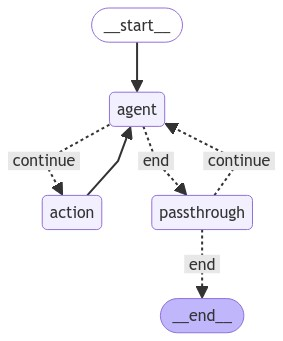

In [490]:
from IPython.display import Image, display

bot_with_helpfulness_check=get_state_update_bot_with_helpfullness_node() # type: ignore

try:
    display(Image(bot_with_helpfulness_check.get_graph().draw_mermaid_png()))#state_update_bot
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [491]:
# bot_with_helpfulness_check=get_state_update_bot_with_helpfullness_node()

inputs = {"messages" : [HumanMessage(content=mental_health_counseling_data['test'][12]["Context"])]}

messages = bot_with_helpfulness_check.invoke(inputs)

print_messages(messages)

helpful!
Initial Query: I feel depressed even though I act like a happy with my family. I act like I’m happy so my son doesn’t see me sad. I act like my life is a happy life, but I feel sad and depressed. I sometimes think of killing myself and that my family deserve someone better than me. I just cry and write in my book all these feelings.


Agent Response: I'm sorry to hear that you're feeling this way. It's important to remember that you are not alone and there are people who care about you and want to help. It's brave of you to reach out and talk about your feelings. 

If you are having thoughts of harming yourself, it's crucial to seek help immediately. You can reach out to a mental health professional, a therapist, a counselor, or a helpline for support. Your well-being is important, and there are resources available to help you through this difficult time.

If you're comfortable, I can provide you with some resources or information on how to cope with these feelings. Just let m

In [525]:
mental_health_counseling_data['test'][12]["Response"]

"It sounds like you have several different things happening at the same time. I would encourage you to call and speak to a local therapist. If you are having thoughts of killing yourself in this moment, please call 800-273-8255 and talk to someone.While I follow that you would like your son to be unaware of what you are going through, that doesn't mean that you can't discuss your feelings with someone else. Who is it that you trust or could speak with about this? A therapist could be one person, but perhaps there is someone else in your life as well.One thing that may help is to find a bead or rock that is smooth and you can hold onto it while thinking of a specific memory where you were happy. This could be from as long ago as necessary as long as it is specific and you can place yourself back in that time when you are thinking about it. If you think about this time while holding onto the bead, the bead may remind you of a time when you felt happy. You could do the same thing for a ti

## ADD systemPrompt!

In [511]:
def convert_inputs(input_object):
    system_prompt = f"""You are a qualified psychologist providing mental health advice. Be empathetic in your responses. 
    Always provide a complete response. Be empathetic and provide a follow-up question to find a resolution. 
    First, look up the RAG (retrieval-augmented generation) and then arxiv research or use InternetSearch:



You will operate in a loop of Thought, Action, PAUSE, and Observation. At the end of the loop, you will provide an Answer.

Instructions:

Thought: Describe your thoughts about the user's question.
Action: Choose one of the available actions to gather information or provide insights.
PAUSE: Pause to allow the action to complete.
Observation: Review the results of the action.

Available Actions:

Use the tools at your disposal to look up information or resolve the consultancy. You are allowed to make multiple calls (either together or in sequence).:

    1. rag_tool: RAG (Retrieval-Augmented Generation) to access relevant mental health information.
    2. DuckDuckGoSearchRun: Perform an online search: InternetSearch to find up-to-date resources and recommendations.
    3. ArxivQueryRun: Find relevant research or content.
    3. PubMedQuerRun: Find a specific coping strategies or management techniques by doing research paper

    You may make multiple calls to these tools as needed to provide comprehensive advice.

    Present your final response in a clear, structured format, including a chart of recommended actions if appropriate.

    User's question: {input_object['question']}

    Response: Your task is When responding to users' personal issues or concerns:

1. With a brief empathetic acknowledgment of the user's situation, continue
2. Provide practical, actionable advice that often includes 
3. Suggesting professional help (e.g., therapists, counselors) when appropriate
4. Encouraging open communication and dialogue with involved parties and 
5. Recommending self-reflection or exploration of emotions and values and
6. Offering specific coping strategies or management techniques
"""
    return {"messages": [HumanMessage(content=system_prompt)]}

# Define the function to parse the output
def parse_output(input_state):
    return input_state["messages"][-1].content

bot_with_helpfulness_check=get_state_update_bot_with_helpfullness_node() # type: ignore
# Create the agent chain
agent_chain = convert_inputs | bot_with_helpfulness_check# | StrOutputParser()#| parse_output

# Run the agent chain with the input
messages=agent_chain.invoke({"question": mental_health_counseling_data['test'][14]['Context']})
print_messages(messages)


helpful!
Initial Query: You are a qualified psychologist providing mental health advice. Be empathetic in your responses. 
    Always provide a complete response. Be empathetic and provide a follow-up question to find a resolution. 
    First, look up the RAG (retrieval-augmented generation) and then arxiv research or use InternetSearch:



You will operate in a loop of Thought, Action, PAUSE, and Observation. At the end of the loop, you will provide an Answer.

Instructions:

Thought: Describe your thoughts about the user's question.
Action: Choose one of the available actions to gather information or provide insights.
PAUSE: Pause to allow the action to complete.
Observation: Review the results of the action.

Available Actions:

Use the tools at your disposal to look up information or resolve the consultancy. You are allowed to make multiple calls (either together or in sequence).:

    1. rag_tool: RAG (Retrieval-Augmented Generation) to access relevant mental health information.
 

In [509]:
messages['messages'][-1].content#find('Agent Response:')

"I understand that you are experiencing significant challenges with social interactions and violent thoughts, which have been affecting you for years. It's important to acknowledge the distress and discomfort you are feeling in these situations.\n\nBased on recent research, there is a connection between social anxiety and violent thoughts. Studies have shown that social anxiety can manifest in various ways, including negative perceptions of social interactions and distorted beliefs about how others perceive you. These feelings can contribute to the development of violent thoughts or impulses.\n\nIt's crucial to address these concerns and seek support to improve your mental well-being. Here are some steps you can consider:\n\n1. Seek Professional Help: Consider reaching out to a mental health professional, such as a therapist or counselor, who can provide you with guidance and support in managing social anxiety and violent thoughts.\n\n2. Practice Self-Compassion: Be kind to yourself an

## Chainlit?? How to deploy and what?

In [522]:

import chainlit as cl

@cl.author_rename
def rename(original_author: str):
    """
    This function can be used to rename the 'author' of a message. 

    In this case, we're overriding the 'Assistant' author to be 'Paul Graham Essay Bot'.
    """
    rename_dict = {
        "Assistant" : "Mental Health Advisor Bot"
    }
    return rename_dict.get(original_author, original_author)

@cl.on_chat_start
async def start_chat():
    """
    This function will be called at the start of every user session. 

    We will build our LCEL RAG chain here, and store it in the user session. 

    The user session is a dictionary that is unique to each user session, and is stored in the memory of the server.
    """

    ### BUILD LCEL RAG CHAIN THAT ONLY RETURNS TEXT
    # lcel_rag_chain = ( {"context": itemgetter("query") | hf_retriever, "query": itemgetter("query")}
                      
    #                    | rag_prompt | hf_llm
    #                 )
    bot_with_helpfulness_check=get_state_update_bot_with_helpfullness_node() # type: ignore
    lcel_rag_chain = convert_inputs | bot_with_helpfulness_check

    cl.user_session.set("lcel_rag_chain", lcel_rag_chain)

@cl.on_message  
async def main(message: cl.Message):
    """
    This function will be called every time a message is recieved from a session.

    We will use the LCEL RAG chain to generate a response to the user query.

    The LCEL RAG chain is stored in the user session, and is unique to each user session - this is why we can access it here.
    """
    lcel_rag_chain = cl.user_session.get("lcel_rag_chain")

    msg = cl.Message(content="")

    async for chunk in lcel_rag_chain.astream(
        {"question": message.content},
        config=RunnableConfig(callbacks=[cl.LangchainCallbackHandler()]),
    ):
        await msg.stream_token(chunk)

    await msg.send()

# chainlit run app.py -w

In [514]:
# ! pip install chainlit

In [515]:
import chainlit as cl

2024-07-17 10:55:58 - Created default config file at /home/sahane/AIE3/Week 5/Day 2/.chainlit/config.toml
2024-07-17 10:56:02 - Loaded .env file


## Add first action

In [ ]:
def get_state_update_bot_with_helpfullness_node(): 
    
    graph_with_helpfulness_check = StateGraph(AgentState)

    graph_with_helpfulness_check.add_node("agent", call_model)
    graph_with_helpfulness_check.add_node("action", call_tool)
    graph_with_helpfulness_check.add_node("passthrough", dummy_node)

    graph_with_helpfulness_check.set_entry_point("agent")
    
    graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue" : "action",
        "end" : "passthrough"
    }
    )

    graph_with_helpfulness_check.add_conditional_edges(
        "passthrough",
        check_helpfulness,
        {
            "continue" : "agent",
            "end" : END
        }
    )

    graph_with_helpfulness_check.add_edge("action", "agent")

    return graph_with_helpfulness_check.compile()
